# remake figure 4 from Feng et al.

Steps:
* Determine location of each track

In [1]:
%matplotlib inline
import xarray as xr
from glob import glob
import numpy as np
import pandas as pd
import cartopy.crs as ccrs   # map plots
import cartopy.feature as cfeature
from e3sm_utils import cmclimate
cmap_prect = cmclimate.cm.WhiteBlueGreenYellowRed
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

ModuleNotFoundError: No module named 'e3sm_utils'

In [2]:
try: 
    # this file was created below
    dsa = xr.open_dataset('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/monthly_mcs_count_land_only.nc')
    file_exists = True
except:
    file_exists = False
if file_exists:
    print(dsa.init_loc)
else:
    print('need to reprocess to create monthly_mcs_count_land_only.nc (see below)')

need to reprocess to create monthly_mcs_count_land_only.nc


## Regional definitions using shapefiles

In [2]:
import shapely.geometry as sgeom
import cartopy.io.shapereader as shpreader
from shapely.ops import unary_union
from shapely.prepared import prep

In [3]:
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
reader = shpreader.Reader(states_shp)
states = reader.records()

In [4]:
sgp_states = ['New Mexico', 'Texas', 'Oklahoma', 'Arkansas']
southeast_states = ['Louisiana', 'Mississippi', 'Alabama', 'Georgia', 'Florida', 'South Carolina', 'North Carolina']
ngp_states = ['Montana', 'Wyoming', 'Colorado', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas',
              'Minnesota', 'Iowa', 'Missouri', 'Wisconsin', 'Illinois', 'Indiana']

geoms = [g for g in shpreader.Reader(states_shp).geometries()]
recs = [r for r in shpreader.Reader(states_shp).records()]

region_geoms = {}
for key, val in {'sgp': sgp_states, 'ngp': ngp_states, 'seast': southeast_states}.items():
    rgn_geoms = unary_union([rec.geometry for rec in recs if rec.attributes['name'] in val])
    region_geoms[key] = prep(rgn_geoms)

## Selection definitions

In [5]:
nlon = 320
nlat = 120
months = np.arange(3, 11)

In [6]:
def select_case(name):
    topdir = '/global/cscratch1/sd/crjones/ECP/' + name
    robust_files = sorted(glob(topdir + '/statstb/robust_mcs_tracks*.nc'))
    if 'e3sm-mmf' in topdir:
        years = pd.date_range(start='2001', end='2008', freq='A-JUN')
    else:
        years = pd.date_range(start='2001', end='2004', freq='A-JUN')
    return topdir, robust_files, years

In [7]:
# Fig 2: seasonal frequency of MCS
do_type = 'e3sm'
if do_type == 'e3sm':
    topdir = '/global/cscratch1/sd/crjones/ECP/e3sm'
else:
    topdir = '/global/cscratch1/sd/crjones/ECP/e3sm-mmf'
robust_files = sorted(glob(topdir + '/statstb/robust_mcs_tracks*.nc'))
nlon = 320  # len(pix_ds.lon)
nlat = 120  # len(pix_ds.lat)
seasons = ['MAM', 'JJA', 'SON']
yearly_counts = {}
print(*robust_files, sep='\n')

/global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_20010301_20011031.nc
/global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_20020301_20021031.nc
/global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_20030301_20031031.nc


In [8]:
def calc_mean_position(this_track, require_mcs_status=True):
    """Use largest pf"""
    pf = this_track.isel(nmaxpf=0)  # largest pf
    if require_mcs_status:
        pf = pf.where(pf.pf_mcsstatus == 1)
    lons = pf.pf_lon.values
    lats = pf.pf_lat.values
    valid_pos = ~np.isnan(lons + lats)
    lons = lons[valid_pos]
    lats = lats[valid_pos]
    lons[lons > 180] = lons[lons > 180] - 360
    return lons, lats

In [9]:
def select_mcs_region(this_track, region_geoms, minlen=100):
    if this_track.majoraxislength.max().item() < minlen:
        print('track never large enough')
        return None
    lons, lats = calc_mean_position(this_track)
    pf_length = this_track.pf_length.item()
    if pf_length != len(lats):
        print('unexpected result: pf_length={} but num points={}'.format(pf_length, len(lats)))
    this_region = {reg: 0 for reg in region_geoms.keys()}
    for coords in zip(lons, lats):
        point = sgeom.Point(*coords)
        for reg, geom in region_geoms.items():
            this_region[reg] += geom.contains(point)  # count which point is in which region
            if this_region[reg]/pf_length >= 0.5:
                return reg
    print('no solution found')
    print(this_region)
    return 'other'

## identify which files initiate over land

In [10]:
def link_track_to_pixel_files(this_track, pixel_files, pattern='%Y%m%d_%H%M'):
    # convert basetimes to string following pattern appearing in pixel_files names; drop NaTs
    basetimes = [bt.strftime(pattern) for bt in pd.to_datetime(this_track.base_time.values) if str(bt) != 'NaT']
    file_list = []
    for bt in basetimes:
        # tricky way to append a file matching the pattern if it's there, None if not
        file_list.append(([p for p in pixel_files if bt in p] + [None])[0])
    return file_list

def process_track(this_track, pixel_files):
    """Drop's times where base_time is NaT from this_track and 
    returns truncated this_track and pixel (map) dataSet for this track"""
    this_track = this_track.where(~np.isnat(this_track.base_time), drop=True)
    pixel_file_list = link_track_to_pixel_files(this_track, pixel_files)
    pix_ds = xr.open_mfdataset(pixel_file_list)
    return this_track, pix_ds

In [11]:
# for selection based on landfrac at initialization
ds_landfrac = xr.open_dataset('/global/project/projectdirs/m3312/crjones/e3sm/early_science/ne120_landfrac_720x1440.nc')

def cloudtrack_and_land(pix_ds, track_id, landmask):
    da = pix_ds['cloudtracknumber']
    tot = np.count_nonzero(da == track_id)
    land = np.count_nonzero((da == track_id) & landmask)
    return land, tot

def initiates_over_land(pix_ds, track_id, landmask=None, threshold=0.05):
    if landmask is None:
        landmask = ds_landfrac['LANDFRAC'].sel(lat=pix_ds.lat, lon=pix_ds.lon) > 0.9
    land, tot = cloudtrack_and_land(pix_ds.isel(time=0), track_id, landmask)
    return (land / tot) > threshold

In [12]:
# the main calculation happens here
land_threshold = 0.9
select_only_land_inits = True
landmask = None
land_inits = {}
water_inits = {}
yearly_counts = {}
topdir, robust_files, years = select_case('e3sm')
for robust_mcs_filename in robust_files:
    print('processing file {}'.format(robust_mcs_filename))
    stats_ds = xr.open_dataset(robust_mcs_filename)
    date_range = robust_mcs_filename[-20:-3]  # 200n0301_200n1031
    pixel_files = sorted(glob('{}/mcstracking/{}/mcstrack_*.nc'.format(topdir, date_range)))

    dat_dict = {month: np.zeros((nlat, nlon), dtype=np.int) for month in months}
    tracks_to_process = stats_ds.tracks.values
    # keep track of which start over land and which don't
    land_inits[date_range] = []
    water_inits[date_range] = []
    for track in tracks_to_process:
        this_track, pix_ds = process_track(stats_ds.sel(tracks=track), pixel_files)
        track_id = track + 1
        if landmask is None:
            landmask = ds_landfrac['LANDFRAC'].sel(lat=pix_ds.lat, lon=pix_ds.lon) > land_threshold
        if select_only_land_inits:
            if not initiates_over_land(pix_ds, track_id, landmask=landmask):
                water_inits[date_range].append(track_id)
                print('skipping track ', track_id)
            else:
                land_inits[date_range].append(track_id)
                da = (pix_ds['cloudtracknumber'] == track_id).groupby('time.month').sum(dim='time').load()
                for month in da.month.values:
                    dat_dict[month] += (da.sel(month=month).values > 0).astype(int)
    yearly_counts[date_range] = dat_dict

processing file /global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_20010301_20011031.nc
skipping track  4
skipping track  7
skipping track  13
skipping track  19
skipping track  26
skipping track  29
skipping track  30
skipping track  38
skipping track  41
skipping track  45
skipping track  54
skipping track  55
skipping track  56
skipping track  57
skipping track  58
skipping track  59
skipping track  60
skipping track  61
skipping track  62
skipping track  63
processing file /global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_20020301_20021031.nc
skipping track  4
skipping track  5
skipping track  6
skipping track  9
skipping track  13
skipping track  16
skipping track  17
skipping track  19
skipping track  21
skipping track  22
skipping track  28
skipping track  29
skipping track  36
skipping track  37
skipping track  41
skipping track  44
skipping track  45
skipping track  47
skipping track  49
skipping track  55
skipping track  57
skipping track  58
skippi

## write dataset to file

In [13]:
lons = pix_ds.lon
lats = pix_ds.lat
ntrackmax = 311

In [14]:
data = np.empty((len(years), len(months), len(lats), len(lons)), dtype=np.int)

In [15]:
sorted_keys = sorted([k for k in yearly_counts.keys()])
for ny, yr in enumerate(sorted_keys):
    for ns, month in enumerate(months):
        data[ny, ns, :, :] = yearly_counts[yr][month]

In [16]:
tracks = np.arange(1, ntrackmax, dtype=np.int)
print(tracks)
iland = 1
iwater = 2
# track_output:
track_data = np.zeros((len(years), len(tracks)), dtype=np.int)
for ny, yr in enumerate(sorted_keys):
    land_vals = np.array(land_inits[yr], dtype=np.int) - 1
    nonland_vals = np.array(water_inits[yr], dtype=np.int) - 1
    track_data[ny, land_vals] = iland
    track_data[ny, nonland_vals] = iwater
track_data[0, :]

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

array([1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
da_tracks = xr.DataArray(track_data, coords=[years, tracks],
                         dims=['year', 'track'],
                         name='init_loc',
                         attrs={'units': 'None', 
                                'long_name': 'initiation_location',
                                'notes': '1 = initiates over land, 2 = initiates over water, 0 = no track'}
                        )
# da_tracks

In [18]:
da = xr.DataArray(data, coords=[years, months, lats, lons],
                  dims=['year', 'month', 'lat', 'lon'],
                  name='mcs_count',
                  attrs={'units': 'None', 
                         'long_name': 'monthly_mcs_count',
                         'notes': 'excludes tracks that do not initiate over land'},
                 )
da

<xarray.DataArray 'mcs_count' (year: 3, month: 8, lat: 120, lon: 320)>
array([[[[0, ..., 0],
         ...,
         [0, ..., 0]],

        ...,

        [[0, ..., 0],
         ...,
         [0, ..., 0]]],


       ...,


       [[[0, ..., 0],
         ...,
         [0, ..., 0]],

        ...,

        [[0, ..., 0],
         ...,
         [0, ..., 0]]]])
Coordinates:
  * year     (year) datetime64[ns] 2001-06-30 2002-06-30 2003-06-30
  * month    (month) int64 3 4 5 6 7 8 9 10
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 220.125 220.375 220.625 ... 299.375 299.625 299.875
Attributes:
    units:      None
    long_name:  monthly_mcs_count
    notes:      excludes tracks that do not initiate over land

In [19]:
ds0 = xr.merge([da, da_tracks])
ds0

<xarray.Dataset>
Dimensions:    (lat: 120, lon: 320, month: 8, track: 310, year: 3)
Coordinates:
  * year       (year) datetime64[ns] 2001-06-30 2002-06-30 2003-06-30
  * month      (month) int64 3 4 5 6 7 8 9 10
  * lat        (lat) float32 20.125 20.375 20.625 ... 49.375 49.625 49.875
  * lon        (lon) float32 220.125 220.375 220.625 ... 299.375 299.625 299.875
  * track      (track) int64 1 2 3 4 5 6 7 8 ... 303 304 305 306 307 308 309 310
Data variables:
    mcs_count  (year, month, lat, lon) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    init_loc   (year, track) int64 1 1 1 2 1 1 2 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0

In [20]:
topdir

'/global/cscratch1/sd/crjones/ECP/e3sm'

In [21]:
ds0.to_netcdf(topdir + '/monthly_mcs_count_land_only.nc')

## visualize results

In [27]:
dsx = ds0

In [29]:
# prepare figure canvas:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

In [33]:
dat.lat

<xarray.DataArray 'lat' (lat: 120)>
array([20.125, 20.375, 20.625, 20.875, 21.125, 21.375, 21.625, 21.875, 22.125,
       22.375, 22.625, 22.875, 23.125, 23.375, 23.625, 23.875, 24.125, 24.375,
       24.625, 24.875, 25.125, 25.375, 25.625, 25.875, 26.125, 26.375, 26.625,
       26.875, 27.125, 27.375, 27.625, 27.875, 28.125, 28.375, 28.625, 28.875,
       29.125, 29.375, 29.625, 29.875, 30.125, 30.375, 30.625, 30.875, 31.125,
       31.375, 31.625, 31.875, 32.125, 32.375, 32.625, 32.875, 33.125, 33.375,
       33.625, 33.875, 34.125, 34.375, 34.625, 34.875, 35.125, 35.375, 35.625,
       35.875, 36.125, 36.375, 36.625, 36.875, 37.125, 37.375, 37.625, 37.875,
       38.125, 38.375, 38.625, 38.875, 39.125, 39.375, 39.625, 39.875, 40.125,
       40.375, 40.625, 40.875, 41.125, 41.375, 41.625, 41.875, 42.125, 42.375,
       42.625, 42.875, 43.125, 43.375, 43.625, 43.875, 44.125, 44.375, 44.625,
       44.875, 45.125, 45.375, 45.625, 45.875, 46.125, 46.375, 46.625, 46.875,
       47.125, 4

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


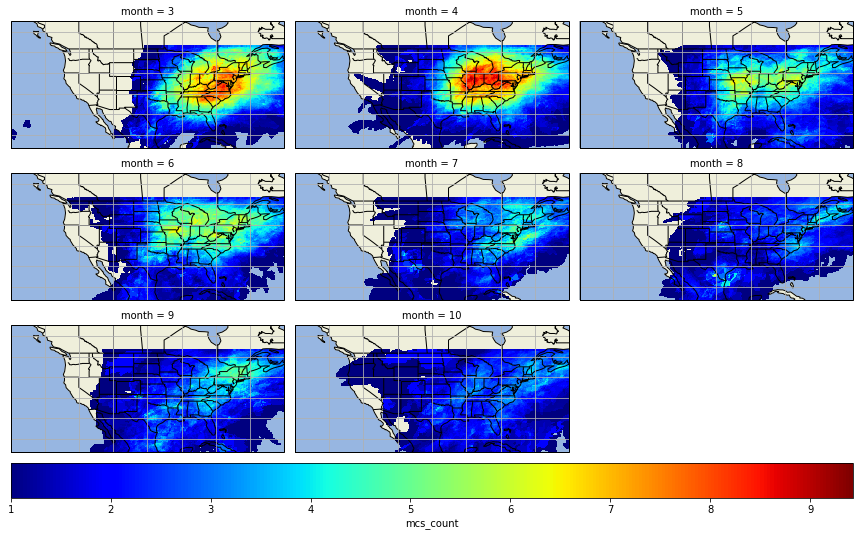

In [35]:
# E3SM

# dat = dsx['seasonal_mcs_count'].astype(np.float)
dat = dsx['mcs_count']
dat = dat.where(dat > 0)
# dat.values[dat.values <1e-3] = np.nan
# levs = range(2, 18, 2)
p = dat.mean(dim='year').plot(col='month', col_wrap=3, transform=ccrs.PlateCarree(),
                              subplot_kws={'projection': ccrs.PlateCarree()},
                              cbar_kwargs={'orientation': 'horizontal', 'pad': 0.02, 'aspect': 24},
                              cmap=plt.cm.jet, figsize=(12, 8))
for ax in p.axes.flatten():
    ax.add_feature(states_provinces, edgecolor='black', alpha=1)
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)
    ax.gridlines()
    ax.set_extent([dat.lon.values[0], dat.lon.values[-1], dat.lat.values[0], dat.lat.values[-1]])

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


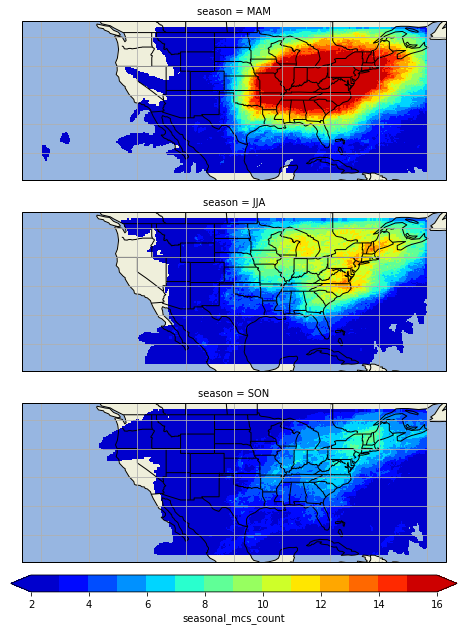

In [94]:
# E3SM-MMF: 
ds_mmf = xr.open_dataset('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/seasonal_mcs_count_land_only.nc')
# dat = dsx['seasonal_mcs_count'].astype(np.float)
dat = ds_mmf['seasonal_mcs_count']
dat = dat.where(dat > 0)
# dat.values[dat.values <1e-3] = np.nan
levs = range(2, 17, 1)
p = dat.mean(dim='year').plot(row='season', transform=ccrs.PlateCarree(),
                                                subplot_kws={'projection': ccrs.PlateCarree()},
                                                cbar_kwargs={'orientation': 'horizontal', 'pad': 0.02, 'aspect': 24},
                                                cmap=plt.cm.jet, figsize=(8, 12),
                                                levels=levs,
                                               )
for ax in p.axes.flat:
    ax.add_feature(states_provinces, edgecolor='black', alpha=1)
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)
    ax.gridlines()

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


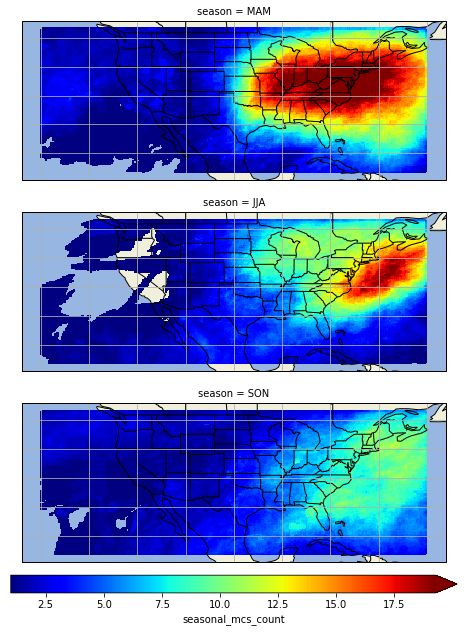

In [29]:
# MMF
# older version that includes *all* tracks, not just over land
# note that clear shift to much MCS activity off the coast
ds_mmf = xr.open_dataset('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/seasonal_mcs_count.nc')
dat = ds_mmf['seasonal_mcs_count']
dat = dat.where(dat > 0)
p = dat.mean(dim='year').plot(row='season', transform=ccrs.PlateCarree(),
                              subplot_kws={'projection': ccrs.PlateCarree()},
                              cbar_kwargs={'orientation': 'horizontal', 'pad': 0.02, 'aspect': 24},
                              cmap=plt.cm.jet, figsize=(8, 12), robust=True,
                             )
for ax in p.axes.flat:
    ax.add_feature(states_provinces, edgecolor='black', alpha=1)
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)
    ax.gridlines()